## Introduction
Support vector machines are a method of binary classification. The basic idea is to find a linear separating line (or hyperplane) between the two classes. We first assume that the binary class targets are -1 or 1, instead of the prior 0 or 1 targets. Since there may be many lines that separate two classes, we define the best linear separator that maximizes the distance between both classes.

We first load the necessary libraries, which includes the scikit learn datasets so that we can load the iris data. Then we will start a graph session. Use the following code:

In [54]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from sklearn import datasets
sess = tf.Session()

Next we will load the iris data, extract the sepal length and petal width, and separated the x and y values for each class (for plotting purposes later) , as follows:

In [55]:
iris = datasets.load_iris()
x_vals = np.array([[x[0], x[3]] for x in iris.data])
y_vals = np.array([1 if y==0 else -1 for y in iris.target])
class1_x = [x[0] for i,x in enumerate(x_vals) if y_vals[i]==1]
class1_y = [x[1] for i,x in enumerate(x_vals) if y_vals[i]==1]
class2_x = [x[0] for i,x in enumerate(x_vals) if y_vals[i]==-1]
class2_y = [x[1] for i,x in enumerate(x_vals) if y_vals[i]==-1]

In [56]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

Now we declare our batch size (larger batches are preferred), placeholders, and the model variable, b , as follows:

In [57]:
batch_size = 100
x_data = tf.placeholder(shape=[None, 2], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)
prediction_grid = tf.placeholder(shape=[None, 2], dtype=tf.float32)
b = tf.Variable(tf.random_normal(shape=[1,batch_size]))

Next we declare our Gaussian kernel. This kernel is dependent on the gamma value, and we will illustrate the effects of various gamma values on the classification later. Use the following code:

In [58]:
gamma = tf.constant(-15.0)
dist = tf.reduce_sum(tf.square(x_data), 1)
dist = tf.reshape(dist, [-1,1])
sq_dists = tf.add(tf.subtract(dist, tf.multiply(2., tf.matmul(x_data,tf.transpose(x_data)))), tf.transpose(dist))
my_kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_dists)))

model_output = tf.matmul(b, my_kernel)
first_term = tf.reduce_sum(b)
b_vec_cross = tf.matmul(tf.transpose(b), b)
y_target_cross = tf.matmul(y_target, tf.transpose(y_target))
second_term = tf.reduce_sum(tf.multiply(my_kernel, tf.multiply(b_vec_cross,
y_target_cross)))
loss = tf.negative(tf.subtract(first_term, second_term))

In order to perform predictions using an SVM, we must create a prediction kernel function. After that, we also declare an accuracy calculation, which will just be a percentage of points correctly classified. Use the following code:

In [59]:
rA = tf.reshape(tf.reduce_sum(tf.square(x_data), 1),[-1,1])
rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), 1),[-1,1])
pred_sq_dist = tf.add(tf.subtract(rA, tf.multiply(2., tf.matmul(x_data,
tf.transpose(prediction_grid)))), tf.transpose(rB))
pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist)))
prediction_output = tf.matmul(tf.multiply(tf.transpose(y_target),b),
pred_kernel)
prediction = tf.sign(prediction_output-tf.reduce_mean(prediction_output))
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction),
tf.squeeze(y_target)), tf.float32))

Next we declare our optimizer function and initialize the variables, as follows:

In [60]:
my_opt = tf.train.GradientDescentOptimizer(0.01)
train_step = my_opt.minimize(loss)
init = tf.initialize_all_variables()
sess.run(init)

Now we can start the training loop. We run the loop for 300 iterations and will store the loss value and the batch accuracy. Use the following code:

In [61]:
loss_vec = []
batch_accuracy = []
for i in range(300):
    rand_index = np.random.choice(len(x_vals), size=batch_size)
    rand_x = x_vals[rand_index]
    rand_y = np.transpose([y_vals[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)
    acc_temp = sess.run(accuracy, feed_dict={x_data: rand_x, y_target: rand_y,prediction_grid:rand_x})
    batch_accuracy.append(acc_temp)

In order to plot the decision boundary, we will create a mesh of x, y points and evaluate the prediction function we created on all of these points, as follows:

In [62]:
x_min, x_max = x_vals[:, 0].min() - 1, x_vals[:, 0].max() + 1
y_min, y_max = x_vals[:, 1].min() - 1, x_vals[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),np.arange(y_min, y_max, 0.02))
grid_points = np.c_[xx.ravel(), yy.ravel()]
[grid_predictions] = sess.run(prediction, feed_dict={x_data:rand_x,
y_target:rand_y,prediction_grid: grid_points})
grid_predictions = grid_predictions.reshape(xx.shape)

For succinctness, we will only show how to plot the points with the decision
boundaries. Use the following code:

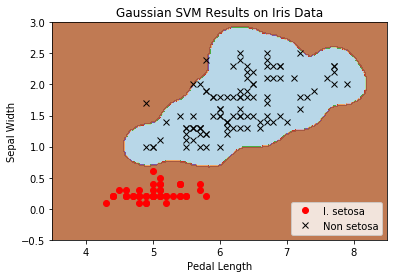

In [63]:
plt.contourf(xx, yy, grid_predictions, cmap=plt.cm.Paired,
alpha=0.8)
plt.plot(class1_x, class1_y, 'ro', label='I. setosa')
plt.plot(class2_x, class2_y, 'kx', label='Non setosa')
plt.title('Gaussian SVM Results on Iris Data')
plt.xlabel('Pedal Length')
plt.ylabel('Sepal Width')
plt.legend(loc='lower right')
plt.ylim([-0.5, 3.0])
plt.xlim([3.5, 8.5])
plt.show()
